In [3]:
!pip install tensorflow-gpu
!pip install keras
!pip install plotly
!pip install cufflinks
!pip install chart_studio


In [2]:
#Imports

import tensorflow
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#import chart_studio.plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import chart_studio.plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
#from chart_studio.plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
STOPWORDS = stopwords

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

TensorFlow is already loaded. Please restart the runtime to change versions.


<tf.Tensor: id=35, shape=(), dtype=float32, numpy=-159.6372>

<tf.Tensor: id=70, shape=(), dtype=float32, numpy=-2084.7812>

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.301257886000002
GPU (s):
0.0641106260000015
GPU speedup over CPU: 82x


In [0]:
#Reading in data

df = pd.read_csv('df_5mil.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

In [10]:
df.isna().mean()

type      0.000000
title     0.000000
tokens    0.000000
lemma     0.000009
dtype: float64

In [0]:
df.dropna(inplace=True)

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(df['lemma'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 683190 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['lemma'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5691624, 50)


In [14]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5691624, 5)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5122461, 50) (5122461, 5)
(569163, 50) (569163, 5)


In [18]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 5,061,105
Trainable params: 5,061,105
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
epochs = 10
batch_size = 1024

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)], verbose=1)

Train on 4610214 samples, validate on 512247 samples
Epoch 1/10
4610214/4610214 [==============================] - 583s 127us/sample - loss: 0.7286 - accuracy: 0.7183 - val_loss: 0.7921 - val_accuracy: 0.6926
Epoch 2/10
4610214/4610214 [==============================] - 580s 126us/sample - loss: 0.7075 - accuracy: 0.7260 - val_loss: 0.7787 - val_accuracy: 0.6976
Epoch 3/10
4610214/4610214 [==============================] - 578s 125us/sample - loss: 0.8715 - accuracy: 0.7300 - val_loss: 0.7807 - val_accuracy: 0.6957
Epoch 4/10
4610214/4610214 [==============================] - 581s 126us/sample - loss: 0.6856 - accuracy: 0.7346 - val_loss: 0.7709 - val_accuracy: 0.7021
Epoch 5/10
4610214/4610214 [==============================] - 581s 126us/sample - loss: 0.6839 - accuracy: 0.7369 - val_loss: 0.7624 - val_accuracy: 0.7034
Epoch 6/10
4610214/4610214 [==============================] - 583s 126us/sample - loss: 0.7249 - accuracy: 0.7314 - val_loss: 0.7612 - val_accuracy: 0.7019
Epoch 7/10


NameError: ignored

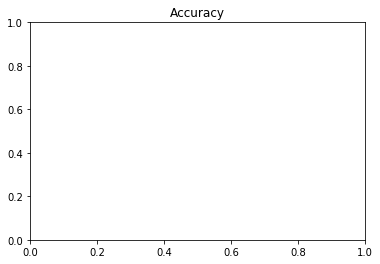

In [3]:

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train', color = 'violet')
plt.plot(history.history['val_accuracy'], label='test', color = 'blue')
plt.legend()
plt.show();